<a href="https://colab.research.google.com/github/guanchengli97/NodeClassification/blob/main/NodeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch


from sklearn.preprocessing import LabelEncoder
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# df = pd.read_csv('/content/drive/MyDrive/recsys2015/yoochoose-clicks.dat', header=None)
# df.columns=['session_id','timestamp','item_id','category']

# buy_df = pd.read_csv('/content/drive/MyDrive/recsys2015/yoochoose-buys.dat', header=None)
# buy_df.columns=['session_id','timestamp','item_id','price','quantity']

# item_encoder = LabelEncoder()
# df['item_id'] = df['item_id'].astype(int)
# df['item_id'] = item_encoder.fit_transform(df.item_id)
# df.head()

# np.random.seed(42)

# with open('/content/drive/MyDrive/recsys2015/yoochoose-clicks.dat','rb') as f:
#     df = pickle.load(f)

# df.head(5)


df = pd.read_csv('/content/drive/MyDrive/recsys2015/yoochoose-clicks.dat', header=None)
df.columns=['session_id','timestamp','item_id','category']



buy_df = pd.read_csv('/content/drive/MyDrive/recsys2015/yoochoose-buys.dat', header=None)
buy_df.columns=['session_id','timestamp','item_id','price','quantity']

buy_df.head()




<ipython-input-1-d2ecad4d5d5a>:32: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/recsys2015/yoochoose-clicks.dat', header=None)


,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1


In [2]:

buy_df.nunique()

df.nunique()

df['valid_session'] = df.session_id.map(df.groupby('session_id')['item_id'].size() > 2)
df = df.loc[df.valid_session].drop('valid_session',axis=1)
df.nunique()


# #randomly sample a couple of them
sampled_session_id = np.random.choice(df.session_id.unique(), 1000000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df.nunique()

df.isna().sum()

# average length of session
df.groupby('session_id')['item_id'].size().mean()

5.560917

In [3]:

from sklearn.preprocessing import LabelEncoder

item_encoder = LabelEncoder()
category_encoder = LabelEncoder()
df['item_id'] = df['item_id'].astype(int)
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head()


df['label'] = df.session_id.isin(buy_df.session_id)
df.head()


df.drop_duplicates('session_id')['label'].mean()

0.085386

In [4]:
!pip install torch-geometric

In [5]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['/content/drive/MyDrive/recsys2015/yoochoose_click_binary_1M_sess.dataset']

    def download(self):
        pass

    def process(self):

        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes,
                                   target_nodes], dtype=torch.long)
            x = node_features

            y = torch.FloatTensor([group.label.values[0]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [6]:
from torch_geometric.data import Data
dataset = YooChooseBinaryDataset(root='/content/drive/MyDrive/recsys2015/')

In [7]:

dataset = dataset.shuffle()
one_tenth_length = int(len(dataset) * 0.1)
train_dataset = dataset[:one_tenth_length * 8]
val_dataset = dataset[one_tenth_length*8:one_tenth_length * 9]
test_dataset = dataset[one_tenth_length*9:]
len(train_dataset), len(val_dataset), len(test_dataset)

(160000, 20000, 20000)

In [8]:
from torch_geometric.data import DataLoader
batch_size= 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:

num_items = df.item_id.max() + 1
num_items

37451

In [10]:

import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]


        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))


        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)

        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)

        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)

        return new_embedding


In [11]:
embed_dim = 128
from torch_geometric.nn import GraphConv, TopKPooling, GatedGraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)

        x = F.relu(self.conv1(x, edge_index))

        # print(self.pool1(x, edge_index, None, batch))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))

        x, edge_index, _, batch, _,_ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _,_ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

In [12]:

device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
crit = torch.nn.BCELoss()

In [13]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

In [14]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

    predictions = np.hstack(predictions)
    labels = np.hstack(labels)

    return roc_auc_score(labels, predictions)

Epoch: 000, Loss: 0.38983, Train Auc: 0.42405, Val Auc: 0.41623, Test Auc: 0.41910
Epoch: 001, Loss: 0.30239, Train Auc: 0.50937, Val Auc: 0.48886, Test Auc: 0.48592
Epoch: 002, Loss: 0.28974, Train Auc: 0.67532, Val Auc: 0.65046, Test Auc: 0.63932
Epoch: 003, Loss: 0.28038, Train Auc: 0.70507, Val Auc: 0.67005, Test Auc: 0.65757
Epoch: 004, Loss: 0.27409, Train Auc: 0.72624, Val Auc: 0.67918, Test Auc: 0.66591
Epoch: 005, Loss: 0.26894, Train Auc: 0.74737, Val Auc: 0.68664, Test Auc: 0.67347
Epoch: 006, Loss: 0.26359, Train Auc: 0.76535, Val Auc: 0.69131, Test Auc: 0.67872
Epoch: 007, Loss: 0.25891, Train Auc: 0.78080, Val Auc: 0.69349, Test Auc: 0.68228
Epoch: 008, Loss: 0.25442, Train Auc: 0.79422, Val Auc: 0.69420, Test Auc: 0.68308
Epoch: 009, Loss: 0.24988, Train Auc: 0.80613, Val Auc: 0.69501, Test Auc: 0.68286
Epoch: 010, Loss: 0.24593, Train Auc: 0.81714, Val Auc: 0.69420, Test Auc: 0.68151
Epoch: 011, Loss: 0.24133, Train Auc: 0.82719, Val Auc: 0.69284, Test Auc: 0.67948
Epoc

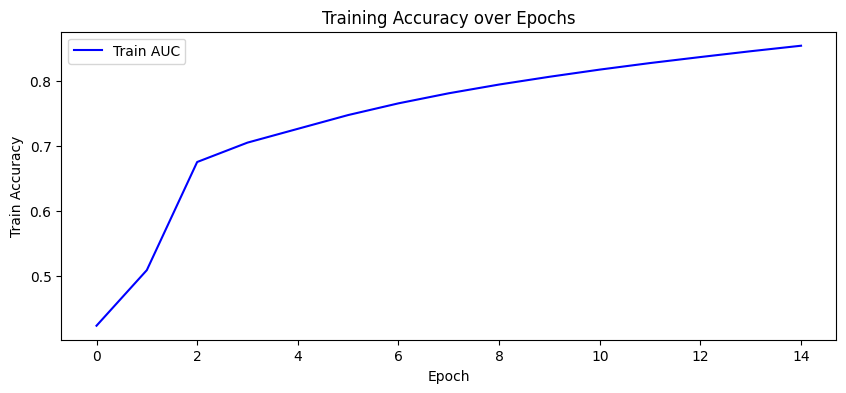

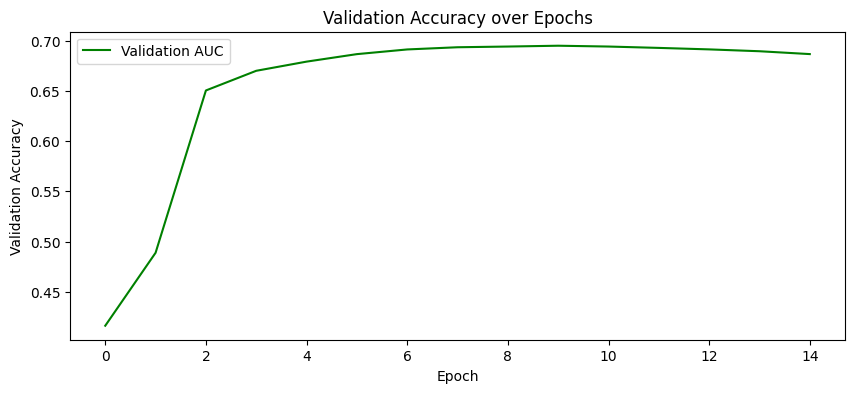

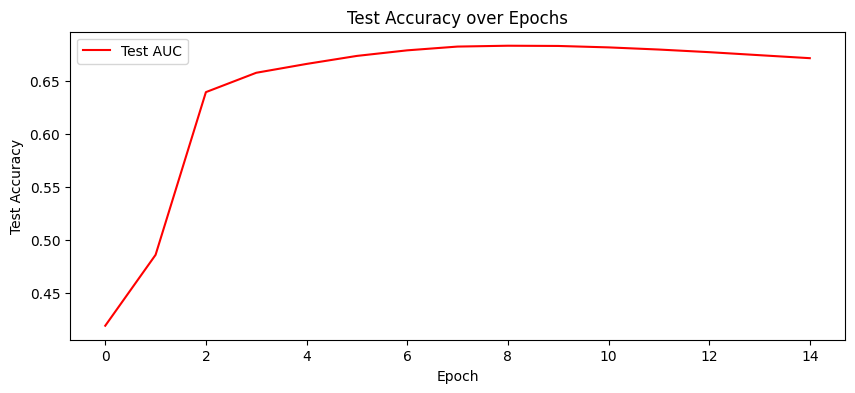

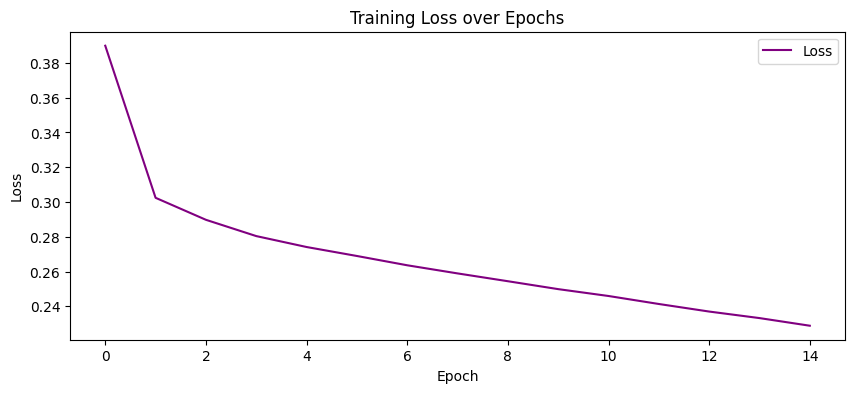

In [15]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
train_accs, val_accs, test_accs, losses = [], [], [], []

for epoch in range(15):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)
    losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train AUC', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(val_accs, label='Validation AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(test_accs, label='Test AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(losses, label='Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()